# A/B Testing
## Analyzing an A/B Test of Two Web Page Presentations vs various demographic/user categories

### About the Dataset

#### A/B Test

The A/B test was performed for an online shopping webpage. The A-Version is the current webpage version, used by the control group, and B-Version is the proposed webpage version, used by the treatment group.

**CONVERSION:** In this A/B test, conversion is the purchase of items by the user. The test also keeps track of purchase amounts, allowing us to evaluate the success of B-Version in terms of revenue.

**Users:** The test is performed in 7 different countries. All users are registered. From registration we have user information on their location and age (mandatory registration fields). User sex is an optional registration field, and therefore remains unspecified for some users.

#### Dataset Description – A/B Testing Data

This dataset contains 294,478 rows and 12 columns, capturing user behavior, demographics, and experimental conditions for an A/B testing experiment. It can be used to analyze differences between control and treatment groups, user engagement, and conversion/purchase behavior. 



**Columns Overview**

- **user_id** (string): Unique identifier for each user.
- **timestamp** (datetime): The date and time of the user’s recorded session.
- **group** (string): A/B test group assignment:
	control → users exposed to the old version.
	treatment → users exposed to the new version.
- **landing_page** (string): The webpage shown to the user (old_page or new_page).
- **converted** (int: 0/1): Indicates whether the user converted (1 = yes, 0 = no).
- **age** (integer): User’s age in years.
- **sex** (string): Sex of the user (Male, Female, Unspecified).
- **location** (string): User’s location (country: e.g., Pakistan, UK, US).
- **session_duration** (float): Length of session in minutes.
- **pages_visited** (integer): Number of pages visited during the session.
- **device_type** (string): Device used to access the platform (Mobile, Tablet, Desktop).
- **purchase_amount** (float): Amount of money ($) spent during the session (0 if no purchase).

* ! We are also provided with the Cost Per Incremental Conversion (CPIC) per country = the estimated dollar amount required in investment to achive a unit increament of conversion rate. 

#### Data Quality
- No missing values across all columns. 
- Data types are appropriate (numeric, categorical, datetime). 
- Large enough sample size (≈ 294k rows) for reliable statistical analysis. **However** if the dataset subgroups are used for analysis, their sample size can be small and may not lead to statistically significant results. 

### Potential Uses
- Compare conversion rates between control and treatment groups. 
- Analyze user behavior by device type, sex, and location. 
- Explore whether session duration, age, or pages visited influence conversion. 
- Study purchase patterns and revenue impact of the new landing page.

## This Project's scope

The company has commissioned an analysis of the experimental data with the mandate to deliver an investment strategy that maximizes revenue and growth potential across all markets. The company has a number of promotional actions it can use to increase user base (bring in more registrations) or encourage more spending from already registered users. This analysis therefore focuses on:


1. Examine the overall success of website's B-Version to proposes whether it's ready for immediate rollout or not, and in which marktes
2. If B-Version is ready for rollout, conduct a ROI analysis on appropriate user segments to propose targeted investment strategies


  

# Initial and Exploratory Data Analysis (IDA/EDA)

The IDA/EDA focuses on inspecting, cleaning and transforming the data, and finding the absolute lift (difference in conversion rate of Version-B from Version-A) to identify where B-Version was measurably successful. The EDA has to conclude on which segments-level should be used for the financial analysis and whether conversion rates alone can be used to reach financial recommendations.

In [1]:
## packages imports
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.cluster import hierarchy
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math

In [2]:
# Functions


# create a function to quickly perform basic, visual data inspection#
def basic_data_inspection(data):
    print('Inspect first 5 rows (and headers if applicable):')
    print('#################################################')
    display(data.head())
    print('#################################################')
    print()
    print('Show data info:')
    print('###############')
    display(data.info())
    print('###############')
    print()
    print('Check if any missing values exist (per column):')
    print('###############################################')
    display(data.isna().sum())
    print('###############################################')
    print()
    print('Show basic stats for numeric variales')
    print('#####################################')
    display(data.describe())
    print('#####################################')


def twoProportion_ztest(n_success,n_obs,alternative='all'):
    """
    Custom function to perfome two-proportion z-test, based on scipy.
    Calculates the 
    """
    #we define 'two-sided' as the default alternative hypothesis
    # n_success and n_obs are imported as arrays or lists. 
    # The function will ensure they're arrays
    n_success=np.array(n_success)
    n_obs=np.array(n_obs)
    # calculate proportions
    p = n_success/n_obs
    p_pool=np.sum(n_success)/np.sum(n_obs)
    # calculate z statistic
    z=-np.diff(p)[0]/(np.sqrt(p_pool*(1-p_pool)*np.sum(1/n_obs)))
    #p-value calculations
    if alternative not in ('two-sided', 'larger', 'smaller','all'):
        print('Invalid alternative argument (valid argument are: two-sided, larger, smaller, all).') 
        print('Defaulting to: all')
        alternative = 'two-sided'
    
    if alternative == 'two-sided':
        pval = 2*(1-norm.cdf(abs(z)))
    elif alternative == 'larger':
        pval = 1-norm.cdf(z)
    elif alternative == 'smaller':
        pval = norm.cdf(z)
    elif alternative == 'all':
        pval = {
            'two-sided': 2 * (1 - norm.cdf(abs(z))),
            'larger': 1 - norm.cdf(z),
            'smaller': norm.cdf(z)
        }       
    return z, pval


def get_lcm(a, b):
    """Simple helper to find the least common multiple."""
    if a == 0 or b == 0: return a + b
    return abs(a * b) // math.gcd(a, b)

# def _draw_pie(ax, df, col, val, colors):
#     """Helper to keep the main loop clean."""
#     counts = df[df[col] == val]['group'].value_counts().reindex(['control', 'treatment']).fillna(0)
#     ax.pie(counts, labels=['Control', 'Treatment'], autopct='%1.1f%%', 
#            startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})
#     ax.set_title(val, fontweight='bold')

def plot_category_ratios(df, category_col=None, n_cols=3, fig_path=None):
    """
    Plots pie charts for subgroups OR the full sample if category_col is None.
    """
    # 1. Determine Subgroups and Totals
    if category_col is None:
        subgroups = ['Full Sample']
        title_main = "Full Sample"
        n_cols=1
    else:
        subgroups = sorted(df[category_col].unique())
        title_main = f'by {category_col.title()}'

    n_total = len(subgroups)
    
    # Adjust n_cols for single plot to avoid empty grid space
    actual_cols = min(n_cols, n_total)
    
    # 2. Grid Geometry (Calculated once)
    n_full_rows = n_total // actual_cols
    n_modulo = n_total % actual_cols
    total_rows = n_full_rows + (1 if n_modulo > 0 else 0)
    
    grid_width = get_lcm(actual_cols, n_modulo) if n_modulo > 0 else actual_cols
    width_full = grid_width // actual_cols
    width_mod = grid_width // n_modulo if n_modulo > 0 else 0

    
    fig = plt.figure(figsize=(actual_cols * 4, total_rows * 4))
    gs = fig.add_gridspec(total_rows, grid_width)
    colors = ['#3498db', '#95a5a6']
    
    idx = 0
    last_wedges = None

    # 3. Unified Plotting Loop
    for r in range(total_rows):
        is_mod_row = (r == total_rows - 1 and n_modulo > 0)
        current_cols = n_modulo if is_mod_row else actual_cols
        current_width = width_mod if is_mod_row else width_full
        offset = (grid_width - (current_cols * current_width)) // 2
        
        for c in range(current_cols):
            start_col = offset + (c * current_width)
            ax = fig.add_subplot(gs[r, start_col : start_col + current_width])
            
            # --- DATA SELECTION LOGIC ---
            # This is the "Efficiency" fix: 
            # Slice by category if provided, otherwise use the whole dataframe
            if category_col is None:
                group_data = df
            else:
                group_data = df[df[category_col] == subgroups[idx]]
            
            counts = (group_data['group'].value_counts()
                      .reindex(['control', 'treatment'])
                      .fillna(0))
            
            # --- THE PIE PLOT (Shared Styling) ---
            wedges, texts, autotexts = ax.pie(
                counts, 
                autopct='%1.1f%%', 
                startangle=90, 
                colors=colors, 
                textprops=dict(color="w", weight="bold", size=14),
                wedgeprops={'edgecolor': 'white', 'linewidth': 1}
            )
            
            if last_wedges is None: last_wedges = wedges
            ax.set_title(subgroups[idx], fontweight='bold', size=12)
            idx += 1

    # 4. Global Legend & Final Layout
    # dynamic_x = 1.25 - (actual_cols * 0.04) # adjust laegend x position by width of plot
    # fig.legend(
    #     last_wedges, ['Control', 'Treatment'], 
    #     title="Group Assignments", loc="upper right",
    #     title_fontsize=13, fontsize=12, bbox_to_anchor=(dynamic_x, 0.9)
    # )
    fig.legend(
    last_wedges, ['Control', 'Treatment'], 
    title="Group Assignments", 
    loc="lower center", 
    bbox_to_anchor=(0.5, -0.05), # Centered horizontally, slightly below the plots
    ncol=2,                      # Puts Control/Treatment side-by-side
    frameon=True
)

    plt.suptitle(f'Group Distribution: {title_main}', fontsize=16, y=1.02)
    plt.tight_layout()
    if fig_path is not None:
        plt.savefig(fig_path, bbox_inches='tight', pad_inches=0.2)
    plt.show()
    # print()
    # return fig


def cr_ztest_initial(df, category_col, category_new_name=None):
    """
    Performs a two-proportion z-test for selected subgroup in a category.
    Returns a formatted DataFrame of results.
    """
    
    if category_new_name is None:
        category_new_name = category_col
        
    category_items = list(df[category_col].unique()) # create category items list to loop over
    
    results = [] # init results list
    
    for item in category_items:
        sub_data = df[df[category_col] == item]
        #verify that the subset is not empty
        if sub_data.empty:
            print(f'data set filtered with: {item} - is empty => skipping')
            continue
            
        # Metrics    
        
        # Calculate total observations (n_obs) and total conversions (n_success) and add to counts dataframe
        counts = sub_data.groupby('group')['converted'].agg(['size', 'sum']) # here, sum will result in the number of conversion == 1
        
        # Ensure the *both* control and treatment groups exist in the sub_data
        # This could happen if a segment is too small or imbalanced
        if 'control' not in counts.index or 'treatment' not in counts.index:
            missing = [] # init missing list
            if 'control' not in counts.index:
                missing.append('control')
            if 'treatment' not in counts.index:
                missing.append('treatment')
            print(f'Skipping subset "{item}" due to missing group(s).')
            print(f"Missing groups: {', '.join(missing)}")
            continue
            
        # define n_obs and n_success
        # ensure control and treatment valeus are in the same order: Control, Treatment
        n_obs = np.array([counts.loc['control', 'size'], counts.loc['treatment', 'size']])
        n_success = np.array([counts.loc['control', 'sum'], counts.loc['treatment', 'sum']])
        # perform two-proportion z-test
        stat, pval = proportions_ztest(n_success, n_obs, alternative='two-sided')
        
        # also calculate conversion rates for reporting
        cr_control = n_success[0] / n_obs[0]
        cr_treatment = n_success[1] / n_obs[1]

        # calculate purchase amounts
        revenue_control = sub_data[sub_data['group'] == 'control'].groupby('group')['purchase_amount'].agg('sum').iloc[0]
        revenue_treatment = sub_data[sub_data['group'] == 'treatment'].groupby('group')['purchase_amount'].agg('sum').iloc[0]
        
        # write results in list of dictionary
        results.append({
                    category_new_name: item,
                    'N_Control': n_obs[0],
                    'CR_Control': cr_control,
                    'N_Treatment': n_obs[1],
                    'absolute_lift_pp':cr_treatment - cr_control, # in percentage points (pp)
                    'absolute_lift_bps':(cr_treatment - cr_control)*10000, # in basis points (bps)
                    'revenue_control':revenue_control,
                    'revenue_treatment':revenue_treatment,
                    'incremental_revenue_$':revenue_treatment-revenue_control,
                    'revenue_uplift_%':((revenue_treatment-revenue_control)/revenue_control)*100,
                    'Z_Stat': stat,
                    'P_Value': pval,
                    'Treatment_Wins': cr_treatment > cr_control,
                    'Significant_at_0.05': pval < 0.05
                })
    
    results_df = pd.DataFrame(results)


    return results_df

def mybarplot(plot_data, x, y, hue, order, ax=None, title='plot_title', 
              x_label='x_label', y_label='y_label', palette='viridis', 
              errorbar=None, legend=False):
    
    # 1. Use default ax if not provided
    if ax is None:
        ax = plt.gca()
    
    # 2. Draw the plot
    sns.barplot(
        data=plot_data, x=x, y=y, hue=hue, ax=ax,
        order=order, palette=palette, errorbar=errorbar, legend=legend
    )
    
    # 3. Annotate
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3) 
    
    # 4. Styling (Using AX methods, not PLT)
    y_max = plot_data[y].max()
    ax.set_ylim(top=y_max * 1.2) # Extra room for labels
    
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.tick_params(axis='x', rotation=45) # Professional way to rotate
    
    return ax # Allows further customization outside the function


# 1) Basic Data Inspection

In [3]:
#load data#
data_df = pd.read_csv('AB_Test_Data.csv')

# define your plot output directory for savefig
# paths are set to expect plots_dir
# Not setting plot_dir will cause errors, unless you change the paths details
plots_dir='YOUR_PATH'

In [4]:
#do basic inspection#
basic_data_inspection(data_df)

Inspect first 5 rows (and headers if applicable):
#################################################


,user_id,timestamp,group,landing_page,converted,age,sex,location,session_duration,pages_visited,device_type,purchase_amount
0,U1,2025-08-02 15:27:54.137058,control,old_page,0,37,Male,Pakistan,3.69,4,Mobile,0.0
1,U2,2024-04-22 10:22:51.712050,treatment,new_page,0,31,Female,UK,1.29,3,Desktop,0.0
2,U3,2024-08-14 21:35:11.135894,treatment,new_page,0,38,Male,US,3.72,5,Desktop,0.0
3,U4,2025-03-19 03:28:51.120807,treatment,new_page,0,28,Female,India,7.76,2,Mobile,0.0
4,U5,2024-12-22 13:13:17.973162,control,old_page,0,33,Male,Australia,6.78,6,Mobile,0.0


#################################################

Show data info:
###############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           294478 non-null  object 
 1   timestamp         294478 non-null  object 
 2   group             294478 non-null  object 
 3   landing_page      294478 non-null  object 
 4   converted         294478 non-null  int64  
 5   age               294478 non-null  int64  
 6   sex               294478 non-null  object 
 7   location          294478 non-null  object 
 8   session_duration  294478 non-null  float64
 9   pages_visited     294478 non-null  int64  
 10  device_type       294478 non-null  object 
 11  purchase_amount   294478 non-null  float64
dtypes: float64(2), int64(3), object(7)
memory usage: 27.0+ MB


None

###############

Check if any missing values exist (per column):
###############################################


user_id             0
timestamp           0
group               0
landing_page        0
converted           0
age                 0
sex                 0
location            0
session_duration    0
pages_visited       0
device_type         0
purchase_amount     0
dtype: int64

###############################################

Show basic stats for numeric variales
#####################################


,converted,age,session_duration,pages_visited,purchase_amount
count,294478.000000,294478.000000,294478.000000,294478.000000,294478.000000
mean,0.149172,31.902084,5.002136,4.019550,5.610490
std,0.356259,9.250043,1.980285,1.965182,15.438006
min,0.000000,18.000000,0.500000,1.000000,0.000000
25%,0.000000,25.000000,3.640000,3.000000,0.000000
50%,0.000000,32.000000,4.990000,4.000000,0.000000
75%,0.000000,38.000000,6.340000,5.000000,0.000000
max,1.000000,65.000000,13.730000,18.000000,269.280000


#####################################


In [5]:
# check if rows are user_id unique (ie if any user_id is duplicated)

print(f" Number of duplicate user_id in database: {data_df['user_id'].duplicated().sum()}")

 Number of duplicate user_id in database: 0


### Observations/Conclusions

* 294478 rows
* 12 columns. 7 object, 3 integer, 2 float
* No duplicates in user_id => Each row is a unique user session
* Average session duration: 5 minutes
* Average pages visited per session: 4 pages
* Average amount spent on purchases: $5.61
* No missing values
* age, and pages visited are discrete variables
* session_duration and purchased_amount are continuous variables
* age, pages, session_duration and purchased_amount are ordinal

* **Important**: For the purposes of this analysis, the following parameters are **not required**: timestamp, session_duration, pages_visited. We therefore remove them to reduce computational resources needed.
* The columns group and landing_page are probably fully correlated. This is true is group='control' necessarily means landing_page='old_page' and group='treatment' necessarily means landing_page='new page'. If that is the case, only one of the two columns is needed. Let's check:

In [6]:
#If both conditions are true, drop the 'landing_page' column
print((data_df[data_df['group'] == 'control']['landing_page'] == 'old_page').all())
print((data_df[data_df['group'] == 'treatment']['landing_page'] == 'new_page').all())

True
True


==> Remove 'landing_page'

In [7]:
# Let's drop unnecessary columns

data_df.drop(['timestamp', 'landing_page', 'session_duration', 'pages_visited'], axis=1, inplace=True)

In [8]:
data_df.info() # confirm drop

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          294478 non-null  object 
 1   group            294478 non-null  object 
 2   converted        294478 non-null  int64  
 3   age              294478 non-null  int64  
 4   sex              294478 non-null  object 
 5   location         294478 non-null  object 
 6   device_type      294478 non-null  object 
 7   purchase_amount  294478 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 18.0+ MB


# 2) Demographics Inspection

## 2.1) Sex statistics

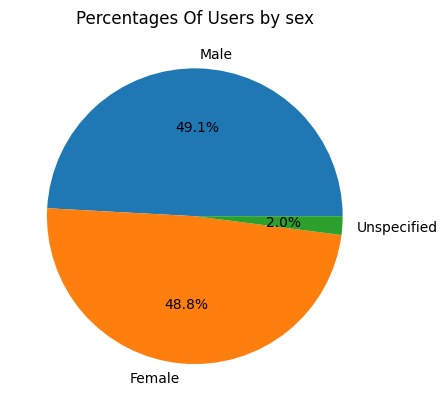

In [9]:
# Percentages of users by sex

#Display percentages
data_df['sex'].value_counts().plot.pie(autopct='%1.1f%%', ylabel='', title='Percentages Of Users by sex')
plt.savefig(plots_dir+'global_sex_pie_chart.png')
plt.show()

### Observations/Conclusions
 
* Female-Male users ratio is practically 1 (0.994)
* For 2% of users, the sex is unspecified. Sex is not an obligatory question during registration (while age is inferred by obligatory the field 'birth date'). 

## 2.2) Age statistics

,index,age
0,count,294478.000000
1,mean,31.902084
2,std,9.250043
3,min,18.000000
4,25%,25.000000
5,50%,32.000000
6,75%,38.000000
7,max,65.000000


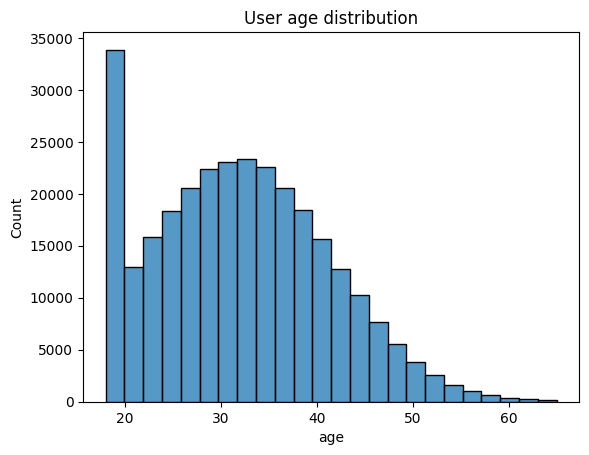

In [10]:
# Check age statistics

hist_data=data_df['age']
display(hist_data.describe().reset_index())

sns.histplot(hist_data, binwidth=2).set(title='User age distribution')
plt.savefig(plots_dir+'global_age_histogram.png')
plt.show()

### Observations/Conclusions

* All users are adults (>= 18)
* The age distribution is Gaussian-like, but with a lower cut-off at 18 and a spike < 20
* Mean and median values are practically identical (31.9 vs 32) - this means that the segment of age < 20 is roughly as large as it would be if the distribution also had a Gaussian tail < 20 (instad of spike).
* The age distribution shows that classic population segmentation (18-24, 25-40, 41-55, 56-65) is possible.
* I proceed and create age groups column (and suplamentary age group columns with shorter notations) and check the age group stats.

In [11]:
bins = [17, 24, 40, 55, 65]
labels_full = ['18-24(Young Adult)', '25-40(Adult)', '41-55(Mid-Life)', '56-65(Mature)']
labels_words = ['Youth', 'Adult', 'Mid', 'Mature']
labels_nums = ['18-24', '25-40', '41-55', '56-65']

# Create the age_group column with full label (better for tables/legends)
data_df['age_group'] = pd.cut(data_df['age'], bins=bins, labels=labels_full)
data_df['age_group_words'] = pd.cut(data_df['age'], bins=bins, labels=labels_words)
data_df['age_nums'] = pd.cut(data_df['age'], bins=bins, labels=labels_nums)

In [12]:
print('Age groups sizes')
display(data_df['age_group'].value_counts().sort_index(level='age_group').reset_index())
print('Age groups proportions')
display((data_df['age_group'].value_counts(normalize=True)*100).sort_index(level='age_group').reset_index())

Age groups sizes


,age_group,count
0,18-24(Young Adult),71509
1,25-40(Adult),168735
2,41-55(Mid-Life),51794
3,56-65(Mature),2440


Age groups proportions


,age_group,proportion
0,18-24(Young Adult),24.283308
1,25-40(Adult),57.299696
2,41-55(Mid-Life),17.588411
3,56-65(Mature),0.828585


**!** Check the 'Mature' segment numbers more closely

In [13]:
mature_users=(data_df.groupby('location')['age_group'].value_counts()).reset_index()
print('Number (counts) of Mature users per country')
print('###########################################')
mature_users[mature_users['age_group']=='56-65(Mature)']

Number (counts) of Mature users per country
###########################################


,location,age_group,count
3,Australia,56-65(Mature),118
7,Canada,56-65(Mature),232
11,Germany,56-65(Mature),267
15,India,56-65(Mature),513
19,Pakistan,56-65(Mature),234
23,UK,56-65(Mature),355
27,US,56-65(Mature),721


### Observations/Conclusions

* The age group with best sampling is 25-40(Adult) at 57.3%.
* The percentages of these age group populations show that, on a global scale, mature (56-65) users in the sample is bolow 1%, and is possible that for specific locations, the number of Mature users may be small, and cause problems in reaching statistically significant conclusions. Below we check the actual number of mature users all locations(countries). They range from 118-721. We should expect that this age group segments, or user subsegments within this age group may not provide statistically significant results when looking for differences in the conversion rates between control and treatment groups.

## 2.3) Device types user statistics

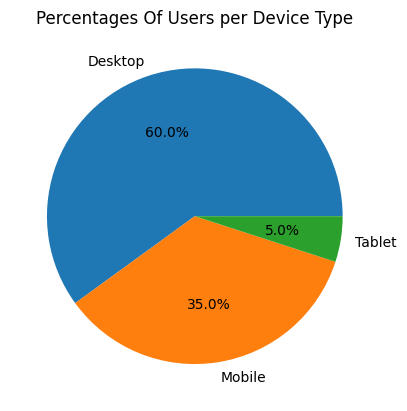

In [14]:
# Percentages of users by device type used

#Display percentages
data_df['device_type'].value_counts().plot.pie(autopct='%1.1f%%', ylabel='', title='Percentages Of Users per Device Type')
plt.savefig(plots_dir+'global_devices_pie_chart.png')
plt.show()

### Observations/Conclusions

* On a global scale, desktop users represent the majority of users, with 60%
* Mobile users represent a significant portion of users, at 35%
* Only 5% of users are in a Tablet. I expect that Tablet users will have a much lower impact on revenue lift unless some Tablet-users subgroups have exceptionally high purchase response with webpage B Version.

## 2.4) Check control-treatment/converion group balance

Let's now quickly visually check the ratios for the treatment Vs control groups for the full sample and for the main subsamples we'll want to investigate, using classic pie charts. The three main subsamples are orgamized by 1) Location (country), 2) Device type, and 3) user sex. 

* Group ratios for full sample

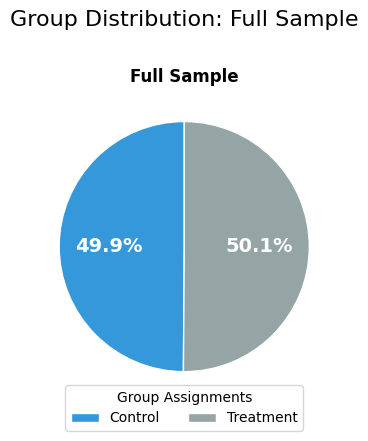

In [15]:
plot_category_ratios(data_df, None, fig_path=plots_dir+'Global_Groups_pie_chart.png')

* Group ratios for basic subsamples

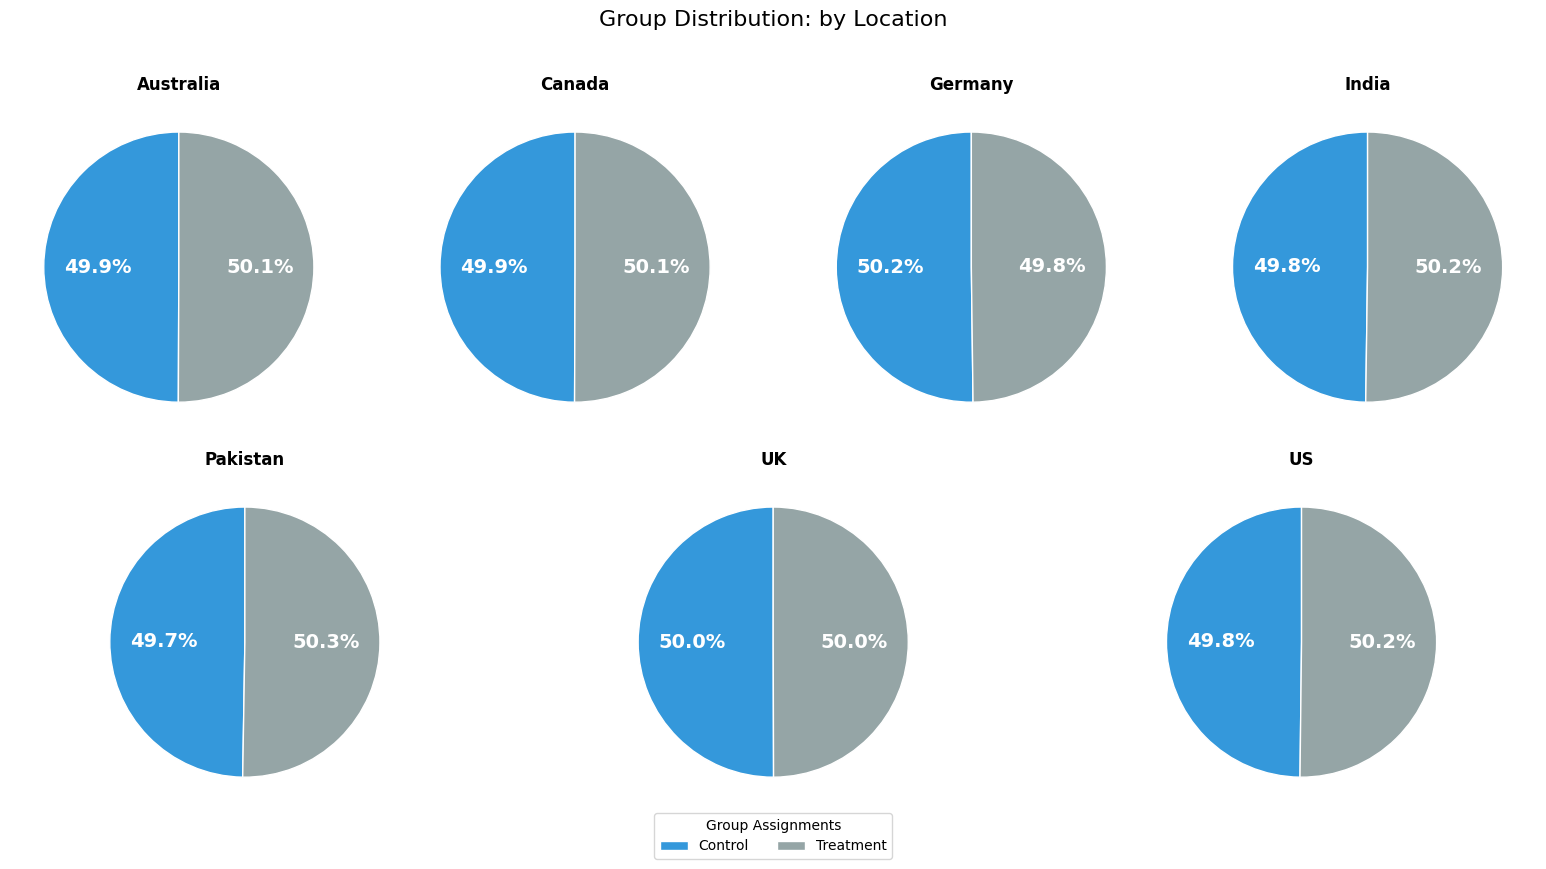

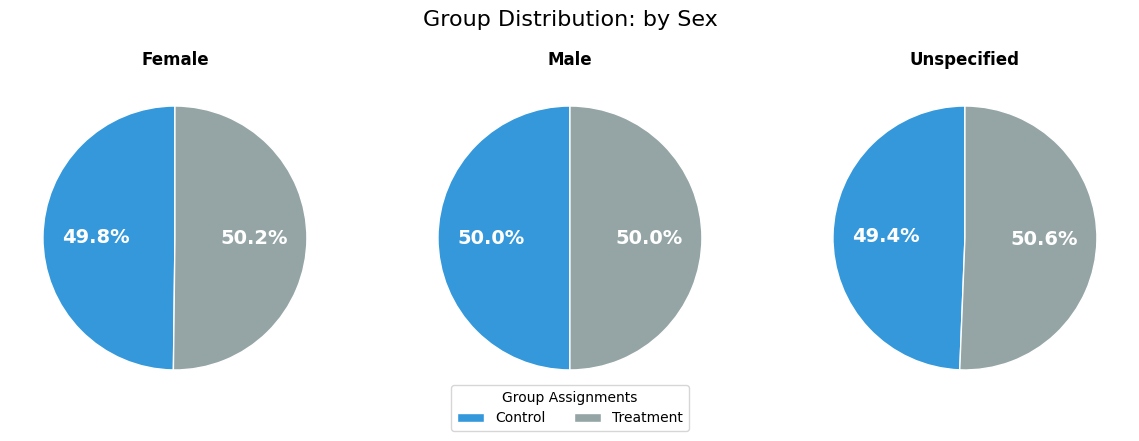

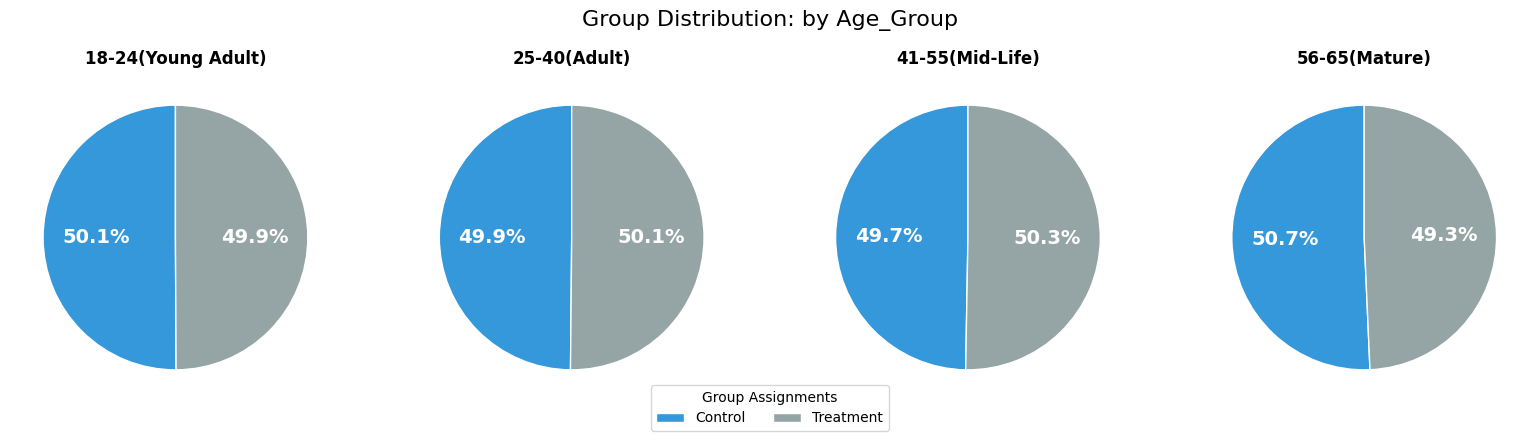

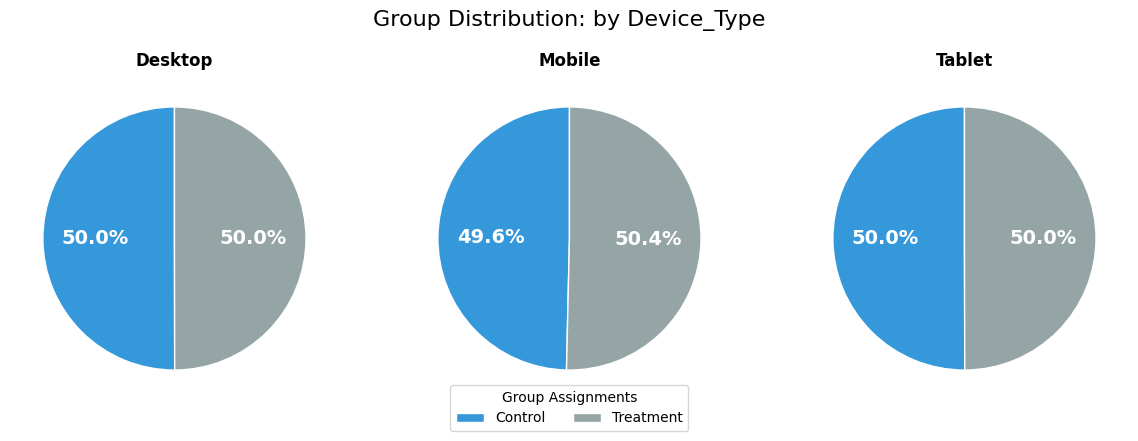

In [16]:
# Ratios per country:
plot_category_ratios(data_df, 'location', 4, fig_path=plots_dir+'Locations_Groups_pie_chart.png')
# Ratios by sex
plot_category_ratios(data_df, 'sex', 3, fig_path=plots_dir+'Global-sex_Groups_pie_chart.png')
# Ratios by age group
plot_category_ratios(data_df, 'age_group', 4, fig_path=plots_dir+'Global-age_Groups_pie_chart.png')
# Ratios by devices
plot_category_ratios(data_df, 'device_type', 3, fig_path=plots_dir+'Global-devices_Groups_pie_chart.png')


### Observations/Conclusions

Because the two groups are quite balanced, both overall (50.1% - 49.9%) and in all major subgroups, and the total number of rows (294478) is very manageable (therefore it will also be very manageable for any subgroup data), I will not do sampling on any major group.

# 3: Compare conversion rates between control and treatment groups in full sample + major groups

## 3.1) Converion rates for full sample and code verification

In [17]:
# Task 1: Compare conversion rates between control and treatment groups. Are they (statistically) different?

* I have already checked that control/treatment groups are balanced.
* I perform two-proportions z-test to check if the conversion rates increases we see are statistically significant. I make two implementations of the method to cross-check the result: 1) using the statsmodel's package z-test implementation, and 2) using my custom function based on scipy functions.
* **Why I perform this comparison**: New versions of python packages occasionally introduce bugs, which sometimes are not found and announced before our own project. This is a quick sanity check that the statsmodel z-test package is bug-free for our needs.

* Method 1: Using the statsmodel package

In [18]:
# Method 1: Using the statsmodel package
# For a two-proportion z-test, statsmodel has the option to use statsmodels.stats.proportion.proportions_ztest
# It is imported as proportions_ztest

# For input, proportions_ztest requires two 1D arrays:
# One array with the values of 'success' counts (in this case, how many converted in each group), 
# and one array with the total number of observations per group (in this case, the total number of users per group).
# These two numbers allow the calculation of proportions

# Let's define the arrays:
n_obs=data_df['group'].value_counts().sort_index(level='group').tolist()
n_success=data_df[data_df['converted'] == 1].groupby(by='group')[['converted']].value_counts().sort_index(level='group').tolist()

# print(n_obs,n_success)

# run proportions_ztest. 

# Remember, there are 3 ways to pose the alternative hypothesis via the 'alternative' argument:
# two-sided: p1!=p2 , ie, the proportions are different (you don’t know which is larger).
# larger: p1>p2 , ie, the first group's conversion rate is larger than the second's.
# smaller: p1<p2 , ie, the second group's conversion rate is larger than the first's.

# We can check if there is any differce at all, using "two-sided"
stat, pval = proportions_ztest(n_success, n_obs, alternative="two-sided")
print(f"Z = {stat}, p-value = {pval}")

Z = -46.277339891305736, p-value = 0.0


### Observations/Conclusions

A p-value of 0. There is strong evidence that the conversion rates in the two groups are different. 
We can check which one has more conversion mathematically.
We calculate the Z statistic and p-values for 'larger' and 'smaller' alternative. 

Recall that the null-hypothesis is that there is no difference in the conversion rates between A-Version and B-Version.

If the B-Version's conversion rate is higher, using alternative="smaller" should return a p-value of 0 (certainty for rejecting null hypothesis) and using alternative="larger" should return a p-value close to 1 (certainty for not rejecting null hypothesis).

In [19]:
stat1, pval1 = proportions_ztest(n_success, n_obs, alternative="smaller")
stat2, pval2 = proportions_ztest(n_success, n_obs, alternative="larger")
print(f"(smaller) Z1 = {stat1}, p-value1 = {pval1}")
print(f"(larger) Z2 = {stat2}, p-value2 = {pval2}")

(smaller) Z1 = -46.277339891305736, p-value1 = 0.0
(larger) Z2 = -46.277339891305736, p-value2 = 1.0


Result: 
* The 'smaller', which means more conversions in the treatment group, has a p-value of 0 => it's correct.
* The 'larger', which means more conversions in the control group, has a p-value 1 => it's wrong.

### Observations/Conclusions

Clearly, more users convert when using the webpage's B-Version (new) when accounting the full (global) sample - ie, it is more likely for a random user (all demographics included) to convert when using the new page design rather than the old.

* Method 2: Manually solving the problem with the help of scipy.stats

In [20]:
# Method 2: Manually solving the problem with the help of scipy.stats

# I do the same proceedure but we build the functions manually. 
# I use the scipy.stats.norm (normal distribution) directly to help us
# I do this to cross-check our statsmodel code.
# If the two codes agree, we'll proceed the rest with statsmodel.
# My custom function is twoProportion_ztest

#define (again n_obs and n_success#
n_obs=data_df['group'].value_counts().sort_index(level='group').tolist()
n_success=data_df[data_df['converted'] == 1].groupby(by='group')[['converted']].value_counts().sort_index(level='group').tolist()

# run z-test
z, pval = twoProportion_ztest(n_success,n_obs,alternative='all')

print(z, pval)

-46.277339891305736 {'two-sided': np.float64(0.0), 'larger': np.float64(1.0), 'smaller': np.float64(0.0)}


### Observations/Conclusions

* My function returns with a single run the results of the three versions of the test (two-sided, larger, smaller)

* We get the same results with the manual function for the z-test. This is confirmation (much increased confidence) of our results and methods. We can use the statsmodel approach in the rest of the analysis.

## 3.2) Conversion rates for sub-groups by location, sex, age group, and device type. 

Perform the same two-proportion z-test, for each major category to check:

* Is the B version the webpage more effective among users of in the different countries?
* Is the B version the webpage more effective among Male or Female users?
* Is the B version the webpage more effective among users of all ages?
* Is the B version the webpage more effective among Desktop, Mobile or Tablet users?


In [21]:
# Run the analysis in all four subgroups
cr_result_countries=cr_ztest_initial(data_df,'location', 'Country')
cr_result_sexes=cr_ztest_initial(data_df,'sex', 'Sex')
cr_result_ages=cr_ztest_initial(data_df,'age_group', 'Age')
cr_result_devices=cr_ztest_initial(data_df,'device_type', 'Device')
##

* **Visualization of lift**

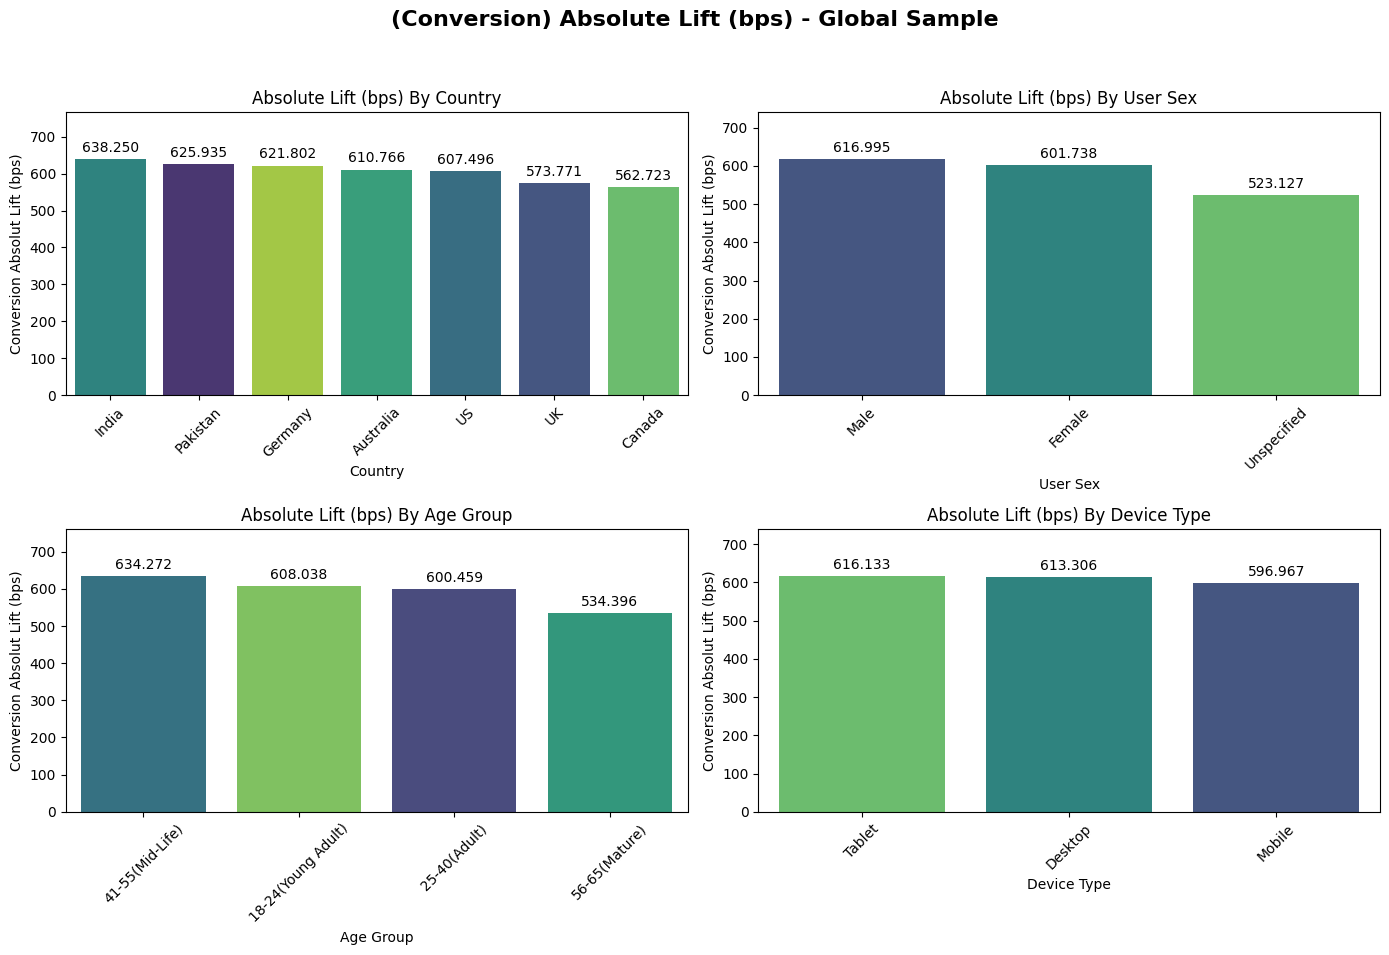

In [22]:
# 1. Define parameters/description as a List of Tuples
# Structure: (dataframe, column_name, x_axis_label, subplot_title)
configs = [
    (cr_result_countries, 'Country', 'Country', 'By Country'),
    (cr_result_sexes, 'Sex', 'User Sex', 'By User Sex'),
    (cr_result_ages, 'Age', 'Age Group', 'By Age Group'),
    (cr_result_devices, 'Device', 'Device Type', 'By Device Type')
]

# 2. Setup the figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 
fig.suptitle('(Conversion) Absolute Lift (bps) - Global Sample', fontsize=16, weight='bold')

# 3. The Loop
for ax, (df, col, label, title) in zip(axes, configs):

    # 1. Ensure the DataFrame is flattened
    # If 'col' is an index, this moves it back to being a column
    df_fixed = df.reset_index() if col not in df.columns else df
    plot_data = df_fixed
    
    
    if not plot_data.empty:
        # Sorting
        sort_order = plot_data.sort_values('absolute_lift_bps', ascending=False)[col]
                
        # Call your custom barplot function
        mybarplot(
            plot_data, 
            x=col, 
            y='absolute_lift_bps', 
            hue=col, 
            order=sort_order, 
            ax=ax, 
            title=f'Absolute Lift (bps) {title}', 
            x_label=label, 
            y_label='Conversion Absolut Lift (bps)',
            palette='viridis', 
            errorbar=None, 
            legend=False
        )
    # else:
    #     # This handles segments where no group reached p < 0.05
    #     ax.set_title(f"No Significant Results {title}")
    #     ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14, color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plots_dir+'global_conversion_lift_bps.png')
plt.show()

### Observations/Conclusions

* All results show increase in conversion rate with p<0.05, so Version B is more successful in converting in all major categories on global scale.
* No marginal results. All conversion lifts are clearly measured without ambiguity.
* **The results show global success of Version B in all user sub-groups.**
* Note that 'Unspecified' sex and '56-65(Mature)' age group have much smaller samples, which lead to significantly smaller |z| values. It is much more likely to reach statistically non-significant results in z-test when analyzing subgroups within these groups, than any others.

I display the full results below to see how other parameters have responded as well. Specifically, beyon the lift, I closely look at:

1) The incremental revenue (in dollars)
2) The Revenue Uplift (percentage), ie the incremental revenue normalized to the control group's revenue, to better better gauge the scale of success in each market/segment.

In [23]:
# Diplay the results #
display(cr_result_countries.sort_values('absolute_lift_bps', ascending=False))
display(cr_result_sexes.sort_values('absolute_lift_bps', ascending=False))
display(cr_result_ages.sort_values('absolute_lift_bps', ascending=False))
display(cr_result_devices.sort_values('absolute_lift_bps', ascending=False))

,Country,N_Control,CR_Control,N_Treatment,absolute_lift_pp,absolute_lift_bps,revenue_control,revenue_treatment,incremental_revenue_$,revenue_uplift_%,Z_Stat,P_Value,Treatment_Wins,Significant_at_0.05
3,India,29378,0.118150,29636,0.063825,638.249897,128849.27,204209.22,75359.95,58.486905,-21.698956,2.098728e-104,True,True
0,Pakistan,14724,0.117495,14876,0.062593,625.934877,65301.56,101002.96,35701.40,54.671588,-15.123010,1.142008e-51,True,True
6,Germany,14798,0.115489,14679,0.062180,621.801990,63672.70,98401.99,34729.29,54.543454,-15.097226,1.688909e-51,True,True
4,Australia,7285,0.118737,7302,0.061077,610.766186,32441.30,50212.96,17771.66,54.780974,-10.348951,4.230952e-25,True,True
2,US,44011,0.118470,44331,0.060750,607.495765,197499.72,297143.55,99643.83,50.452644,-25.356539,7.611503e-142,True,True
1,UK,22127,0.120531,22090,0.057377,573.770785,99460.98,148333.30,48872.32,49.137179,-16.932051,2.611227e-64,True,True
5,Canada,14603,0.122441,14638,0.056272,562.723445,67002.02,98634.38,31632.36,47.211054,-13.451782,3.005424e-41,True,True


,Sex,N_Control,CR_Control,N_Treatment,absolute_lift_pp,absolute_lift_bps,revenue_control,revenue_treatment,incremental_revenue_$,revenue_uplift_%,Z_Stat,P_Value,Treatment_Wins,Significant_at_0.05
0,Male,72348,0.118870,72360,0.061699,616.994688,322254.96,490473.76,168218.80,52.200531,-32.890780,2.977371e-237,True,True
1,Female,71623,0.118258,72162,0.060174,601.737602,318462.92,486479.80,168016.88,52.758695,-32.086795,6.738422e-226,True,True
2,Unspecified,2955,0.126565,3030,0.052313,523.127440,13509.67,20984.80,7475.13,55.331699,-5.619928,1.910370e-08,True,True


,Age,N_Control,CR_Control,N_Treatment,absolute_lift_pp,absolute_lift_bps,revenue_control,revenue_treatment,incremental_revenue_$,revenue_uplift_%,Z_Stat,P_Value,Treatment_Wins,Significant_at_0.05
1,41-55(Mid-Life),25755,0.114153,26039,0.063427,634.271924,111018.38,175642.48,64624.10,58.210271,-20.437318,7.790357e-93,True,True
3,18-24(Young Adult),35811,0.120131,35698,0.060804,608.038200,160933.07,241654.44,80721.37,50.158348,-22.737833,1.893496e-114,True,True
0,25-40(Adult),84123,0.119420,84612,0.060046,600.458970,376174.26,572741.36,196567.10,52.254266,-34.582791,4.584031e-262,True,True
2,56-65(Mature),1237,0.126112,1203,0.053440,534.395620,6101.84,7900.08,1798.24,29.470455,-3.671375,2.412492e-04,True,True


,Device,N_Control,CR_Control,N_Treatment,absolute_lift_pp,absolute_lift_bps,revenue_control,revenue_treatment,incremental_revenue_$,revenue_uplift_%,Z_Stat,P_Value,Treatment_Wins,Significant_at_0.05
2,Tablet,7352,0.118471,7341,0.061613,616.132928,32397.04,49775.36,17378.32,53.641691,-10.479383,1.074428e-25,True,True
1,Desktop,88397,0.119495,88295,0.061331,613.306358,395430.02,600012.74,204582.72,51.736770,-36.085342,3.851132e-285,True,True
0,Mobile,51177,0.117436,51916,0.059697,596.967239,226400.49,348150.26,121749.77,53.776284,-27.026095,7.296090e-161,True,True


### Observations/Conclusions

* The webpage B-Version is also generally successful financially (beyond the basic conversion success).
* However, it is important to note that the success classification changes among the lift, incremental revenue and revenue uplift.
* This reflects differences in market (country) characteristcs and segments sizes on top of their response levels to B-Version.
* It is therefore important to later check the relation between these parameters to decide on the investment strategy.

# 4) Groups to subgroups analysis: Examine results complexity 

* The next step is to examine the lift results in progressively more specific user segments.
* * The **main reason of this examination** is to establish that we are not making the analysis more complicated than needed, as computing resources for the data analysis cost time and money. We therefore want to take advantage of any correlations and symmetries in the data to reduce tha analysis dimensions **without losing analysis information**.
* Each country is considered separately, as it constitutes a different market.
* The user segments are examined in the 2 following progressions:
  1) Sex -> Sex/Age group -> Sex/Age group/Device type (full profile)
  2) Device type -> Device type/Sex -> Sex/Age group/Device type (full profile)
* I proceed only with fully verified users, therefore exclude users with unspecified sex (only 2% of users)

**!! Important:** This EDA based on full user profiles **does not** filter the data to exclude non-significant z-test results. I focus on a first analysis of the trends to make decisions for the final analysis.

In [24]:
# drop users with unspecified sex
data_df=data_df[data_df['sex']!='Unspecified']

In [25]:
# create the aggregated dataframe to be used

agg_df=data_df.groupby(['location', 'sex', 'age_group_words', 'device_type', 'group'], observed=True)['converted'].agg(['size', 'sum']).unstack()

In [26]:
# unify columns by metric and group combinations, as metric_group
agg_df.columns = [f'{metric}_{group}' for metric, group in agg_df.columns]

In [27]:
agg_df['lift_pp'] = (agg_df['sum_treatment'] / agg_df['size_treatment']) - \
                    (agg_df['sum_control'] / agg_df['size_control'])


In [28]:
# agg_df # check df

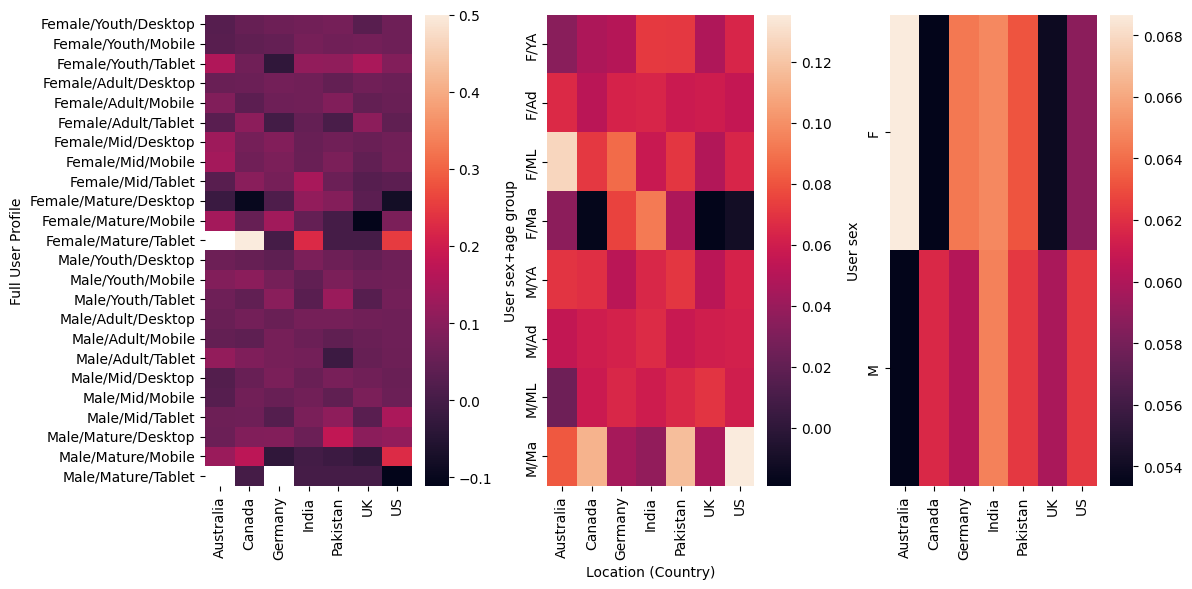

In [29]:
#Examine profile progression (1):

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.axes


# Get the Location vs Sex+age+device=user_profile heatmap: #
# prof_labels=['F-YA', 'F-Ad', 'F-ML', 'F-Ma', 'M-YA', 'M-Ad', 'M-ML', 'M-Ma']
heatmap_loc_user_profile = agg_df.groupby(['sex', 'age_group_words', 'device_type', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_user_profile['lift_pp'] = (heatmap_loc_user_profile['sum_treatment'] / heatmap_loc_user_profile['size_treatment']) - \
                   (heatmap_loc_user_profile['sum_control'] / heatmap_loc_user_profile['size_control'])
lift_series=heatmap_loc_user_profile['lift_pp'].unstack()
lift_series.index = ["/".join(map(str, idx)) for idx in lift_series.index]
# Now pivot for the heatmap
f1=sns.heatmap(lift_series, ax=ax1, cbar=True)
f1.set_xlabel(None)
f1.set_ylabel('Full User Profile')

# Get the Location vs Sex+age heatmap:#
custom_labels=['F/YA', 'F/Ad', 'F/ML', 'F/Ma', 'M/YA', 'M/Ad', 'M/ML', 'M/Ma'] # Quick custom labeling
heatmap_loc_sex_age_data = agg_df.groupby(['sex', 'age_group_words', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_sex_age_data['lift_pp'] = (heatmap_loc_sex_age_data['sum_treatment'] / heatmap_loc_sex_age_data['size_treatment']) - \
                   (heatmap_loc_sex_age_data['sum_control'] / heatmap_loc_sex_age_data['size_control'])

# Now pivot for the heatmap
f2=sns.heatmap(heatmap_loc_sex_age_data['lift_pp'].unstack(), ax=ax2, yticklabels=custom_labels, cbar=True )
f2.set_xlabel('Location (Country)')
f2.set_ylabel('User sex+age group')

# Get the Location vs Sex heatmap: #
heatmap_loc_sex_data = agg_df.groupby(['sex', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_sex_data['lift_pp'] = (heatmap_loc_sex_data['sum_treatment'] / heatmap_loc_sex_data['size_treatment']) - \
                   (heatmap_loc_sex_data['sum_control'] / heatmap_loc_sex_data['size_control'])
# Now pivot for the heatmap

f3=sns.heatmap(heatmap_loc_sex_data['lift_pp'].unstack(), ax=ax3, yticklabels=['F','M'] )
f3.set_xlabel(None)
f3.set_ylabel('User sex')



plt.tight_layout()
plt.savefig(plots_dir+'markets_increased_complexity_sex2profile_lift_bps.png')
plt.show()

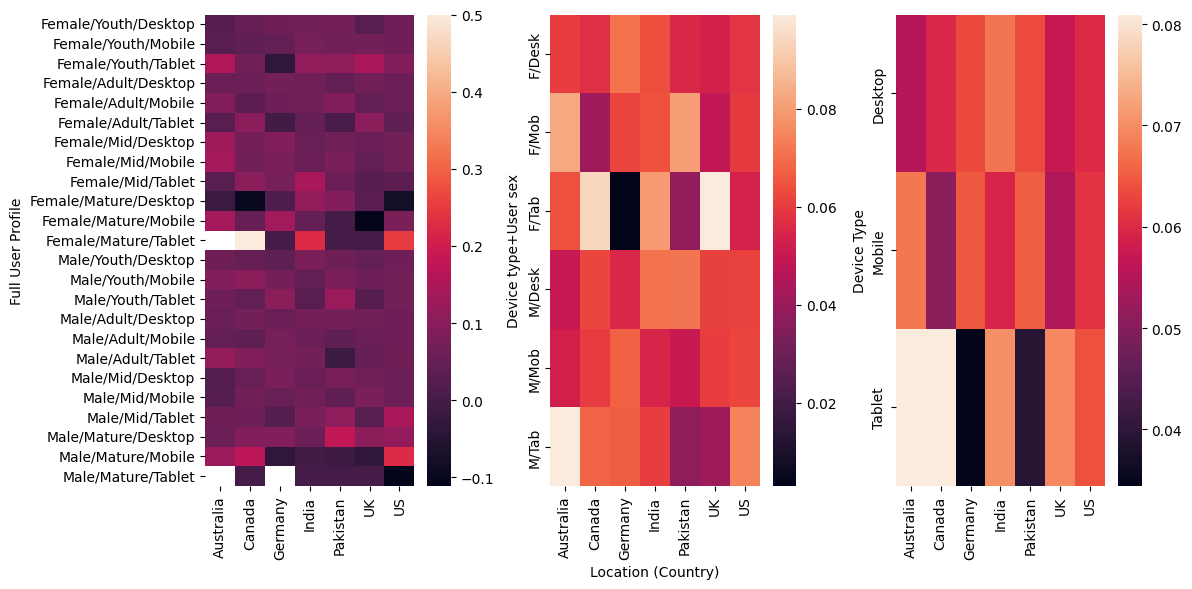

In [30]:
#Examine profile progression (2):

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
f.axes


# Get the Location vs Sex+age+device=user_profile heatmap: #
heatmap_loc_user_profile = agg_df.groupby(['sex', 'age_group_words', 'device_type', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_user_profile['lift_pp'] = (heatmap_loc_user_profile['sum_treatment'] / heatmap_loc_user_profile['size_treatment']) - \
                   (heatmap_loc_user_profile['sum_control'] / heatmap_loc_user_profile['size_control'])
lift_series=heatmap_loc_user_profile['lift_pp'].unstack()
lift_series.index = ["/".join(map(str, idx)) for idx in lift_series.index]
# Now pivot for the heatmap
f1=sns.heatmap(lift_series, ax=ax1, cbar=True)
f1.set_xlabel(None)
f1.set_ylabel('Full User Profile')

# Get the Location vs device type+Sex heatmap:#
custom_labels=['F/Desk', 'F/Mob', 'F/Tab', 'M/Desk', 'M/Mob', 'M/Tab'] # Quick custom labeling
heatmap_loc_device_sex_data = agg_df.groupby(['sex', 'device_type', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_device_sex_data['lift_pp'] = (heatmap_loc_device_sex_data['sum_treatment'] / heatmap_loc_device_sex_data['size_treatment']) - \
                   (heatmap_loc_device_sex_data['sum_control'] / heatmap_loc_device_sex_data['size_control'])

# Now pivot for the heatmap
f2=sns.heatmap(heatmap_loc_device_sex_data['lift_pp'].unstack(), ax=ax2, yticklabels=custom_labels, cbar=True )
f2.set_xlabel('Location (Country)')
f2.set_ylabel('Device type+User sex')

# Get the Location vs device type heatmap: #
heatmap_loc_devices_data = agg_df.groupby(['device_type', 'location'],observed=True)[['size_control', 'sum_control', 'size_treatment', 'sum_treatment']].sum()
# Re-calculate lift on the new aggregated totals
heatmap_loc_devices_data['lift_pp'] = (heatmap_loc_devices_data['sum_treatment'] / heatmap_loc_devices_data['size_treatment']) - \
                   (heatmap_loc_devices_data['sum_control'] / heatmap_loc_devices_data['size_control'])
# Now pivot for the heatmap

f3=sns.heatmap(heatmap_loc_devices_data['lift_pp'].unstack(), ax=ax3 )
f3.set_xlabel(None)
f3.set_ylabel('Device Type')



plt.tight_layout()
plt.savefig(plots_dir+'markets_increased_complexity_device2profile_lift_bps.png')
plt.show()

### Observations/Conclusions

* Increased detail in user segments can change the results significantly.
* Example 1: While the lift has clear difference between the sexes in any country, this cannot lead to recommending prioritizing sales promotions in one over the other, since in certain subgroups, the trend can be reversed. For example, while female users in Australia show significantly higher lift, male young adults have higher lift than female users of the same age group, but female young adults using mobile devices show higher lift than their male counterparts.
* Example 2: While desktop devices in India are clearly associated with higher lift than tablet or mobile devices, tablets perfom better among Inidan female users, and desktop devices do not outprdform mobiles among the female users. In adult female Indian users, however, tablets are in fact the worst performers.
* **The results show that recommendations for the company's response to the A/B test results must be based on users behavior analyzed by their full profile.**

# 5) Lift - Revenue Analysis

I now examine the relations between the conversion lift, the incremental revenue and the revenue uplift.

We have established that we must work using the full user profile per country, so we introduce a new column 'user_profile'.

In [31]:
# introduce 'user_profile' to the data_df
# First create short notation for sex and device type to make user_profile strings shorter

data_df['sex_short'] = data_df['sex'].str[:1]
data_df['device_type_short'] = data_df['device_type'].str[:3]
data_df['user_profile']=data_df['sex_short'].str.cat(data_df['age_group_words'].astype(str), sep='/').str.cat(data_df['device_type_short'], sep='/')

In [32]:
# 1. Aggregate both metrics at once
agg_df = data_df.groupby(
    ['location', 'sex', 'age_group_words', 'device_type', 'group'], 
    observed=True
).agg(
    n_users=('converted', 'size'),
    conversions=('converted', 'sum'),
    total_revenue=('purchase_amount', 'sum')
).unstack()

# 2. Flatten the MultiIndex columns (e.g., 'conversions' + 'control' -> 'conversions_control')
agg_df.columns = [f'{metric}_{group}' for metric, group in agg_df.columns]

# 3. Calculate Conversion Lift (Absolute)
# This is the (Treatment CR) - (Control CR)
agg_df['lift_pp'] = (agg_df['conversions_treatment'] / agg_df['n_users_treatment']) - \
                    (agg_df['conversions_control'] / agg_df['n_users_control'])

# 4. Calculate Incremental Revenue ($)
# This is the absolute increase in total dollars from Control to Treatment
# Formula: (Rev_T - Rev_C) 
agg_df['incremental_revenue_$'] = (agg_df['total_revenue_treatment'] - agg_df['total_revenue_control'])

# 5. Calculate Revenue Uplift (%)
# This is the percentage increase in total dollars from Control to Treatment
# Formula: (Rev_T - Rev_C) / Rev_C
agg_df['revenue_uplift_%'] = (agg_df['total_revenue_treatment'] - agg_df['total_revenue_control']) / \
                            agg_df['total_revenue_control']



* To determine if conversion lift is a sufficient proxy for business success, I first check the lift Vs incremental revenue relation.
* Points are color-coded by country. Each country has 24 points corresponding the 24 user profiles.
* The plot includes a linear regression line (trendline). Specifically it is an area signifying the 95% confidence interval.
* If the lift can fully predict the revenue increase, these two metrics would maintain a strictly linear relationship. By adding a linear regression trendline with a 95% confidence interval, we can visually identify outliers: segments where the "behavioral change" (conversion) does not match the "economic impact" (revenue).
* The distance of a data point from this trendline indicates a deviation from the expected revenue-per-conversion.

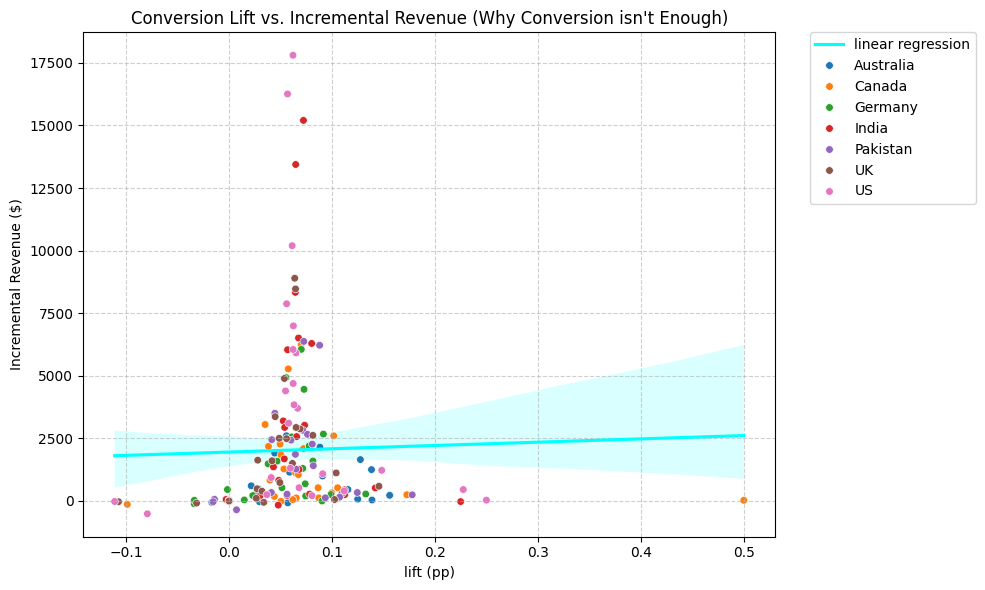

In [33]:
# Plot
plt.figure(figsize=(10, 6))
plot_data=agg_df

sns.regplot(data=plot_data, x='lift_pp', y='incremental_revenue_$', scatter=False, color='cyan', ci=95, label='linear regression')
plt.title("Conversion Lift vs. Incremental Revenue (Why Conversion isn't Enough)")
plt.xlabel('lift (pp)')
plt.ylabel('Incremental Revenue ($)')
sns.scatterplot(
    data=plot_data, 
    x='lift_pp', 
    y='incremental_revenue_$', 
    hue='location', 
    # style='sex', # to note segments by user sex
    #OR#
    # style='device_type', # to note segments by device type
    s=30,
    legend='brief'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(plots_dir+'Lift_Vs_Incremental_Revenue.png')
plt.show()

* While we expect more conversions to equal more money in revenue, this plot reveals a significant deviation. The lack of a strong linear relationship suggests that high conversion gains in certain segments are likely being 'diluted' by low-value transactions.

* The revenue spike observed around the 0.06 pp lift mark indicates that specific, high-velocity segments are driving the bulk of absolute gains, while others exhibit marginal economic returns despite significant behavioral lift.

* The plot demonstrates that the conversion lift is not a sufficient proxy to the financial impact of the webpage B-Version. There's no clear linear relation in which conversion translates to revenue, with revenue spiking around lift of 0.06 pp.

I continue with the same plot but comparing the relation between the incremental revenue and the revenue uplift.

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


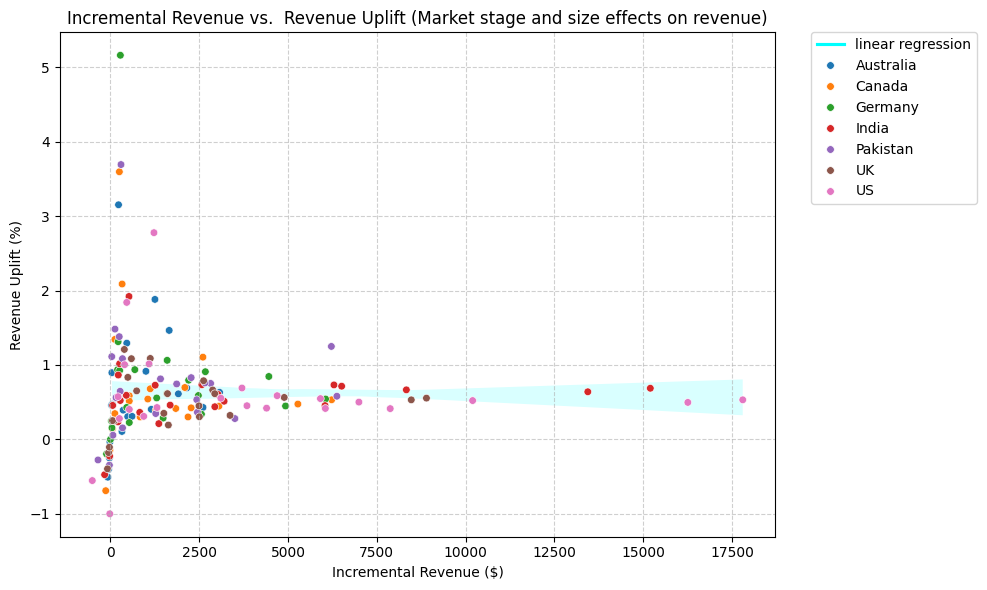

In [34]:
# Plot
plt.figure(figsize=(10, 6))
plot_data=agg_df

sns.regplot(data=plot_data, x='incremental_revenue_$', y='revenue_uplift_%', scatter=False, color='cyan', ci=95, label='linear regression')
plt.title("Incremental Revenue vs.  Revenue Uplift (Market stage and size effects on revenue)")
plt.xlabel('Incremental Revenue ($)')
plt.ylabel('Revenue Uplift (%)')
sns.scatterplot(
    data=plot_data, 
    x='incremental_revenue_$', 
    y='revenue_uplift_%', 
    hue='location',
    # style='sex', # to note segments by user sex
    #OR#
    # style='device_type', # to note segments by device type
    s=30,
    legend='brief'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(plots_dir+'Incremental_Revenue_Vs_Revenue_Uplift.png')
plt.show()

* This comparison shows a threshold effect. For high-value segments (>$3,000), absolute incremental revenue is a reliable predictor of uplift. However, in lower-value segments, the relationship is volatile.

* This confirms that Incremental Revenue alone hides high-growth potential in smaller or emerging markets, while Revenue Uplift alone hides the sheer scale of mature markets. Both must be synthesized to prioritize investments strategically.

Finally, I check how good a predictor can the conversion lift be for the the revenue uplift.

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:4620: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


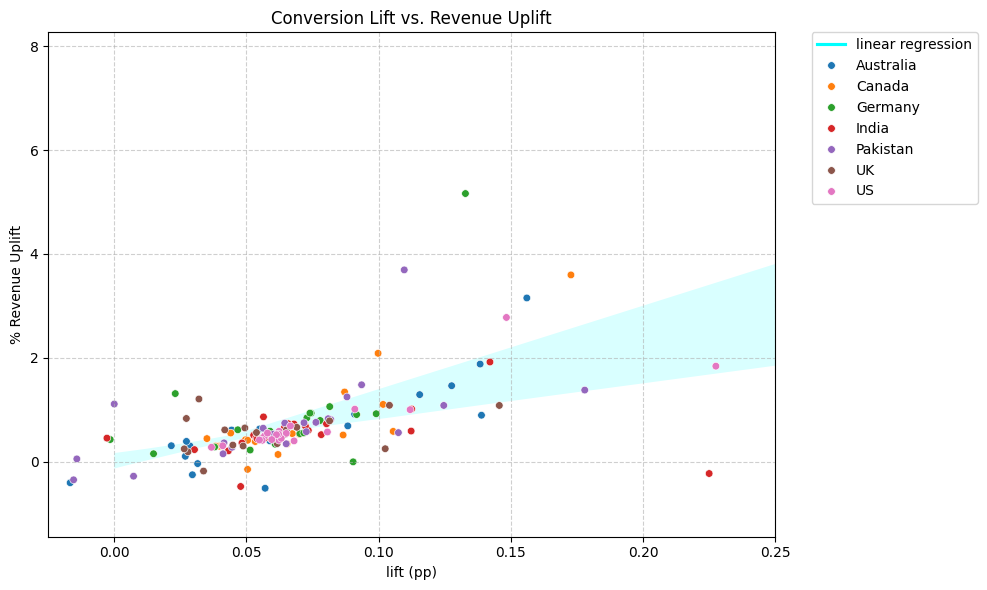

In [35]:
# Plot
plt.figure(figsize=(10, 6))
plot_data=agg_df

sns.regplot(data=plot_data, x='lift_pp', y='revenue_uplift_%', scatter=False, color='cyan', ci=95, label='linear regression')
plt.title("Conversion Lift vs. Revenue Uplift")
plt.xlabel('lift (pp)')
plt.ylabel('% Revenue Uplift')
plt.xlim(right=0.25) # manual limit due an inf point stretching the plot
sns.scatterplot(
    data=plot_data, 
    x='lift_pp', 
    y='revenue_uplift_%', 
    hue='location', 
    # style='sex', # to note segments by user sex
    #OR#
    # style='device_type', # to note segments by device type
    s=30,
    legend='brief'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(plots_dir+'Lift_Vs_Revenue_uplift.png')
plt.show()

* As a normalized metric, revenue uplift tracks more closely with Conversion Lift than absolute dollars do.

* However, the persistence of significant outliers—especially at high lift values—proves that even 'successful' behavioral changes don't always translate to proportional growth. These residuals represent segments where Average Order Value (AOV) is either surging or dropping.

* The revenue uplift remains the best parameter to use as base for development of more accurate scores for strategic investment.

### Observations/Conclusions

1. In this data set, **conversion lift is an imperfect metric to revenue expectation and financial success**:  Relying on it exclusively risks over-investing in high-activity but low-value user behavior.
2. Revenue uplift has a strong correlation with conversion lift, but it's still imperfect. Many segments display significant conversion gains but stagnant revenue, likely due to shifts in Average Order Value (AOV) or product mix.
3. To optimize for immediate revenue-increase impact, the following analysis must move beyond binary Z-tests to a Strategic Investment Priority (SIP) framework, which weights statistical significance against economic scale and acquisition costs.

# 6) Recap: What we need to know for the final analysis


1) The following parameters are not required for this project's analysis and can be safely dropped: 'timestamp', 'landing_page', 'session_duration', 'pages_visited'.
2) Remove rows with users with 'Unspecified' sex.
3) The following new columns are needed: age_group, user profile
4) The data have good balance between the control and treatment groups.
5) The websites B-Version show global success all markets and main user sub-groups (sex, age group, deveice type used).
7) Recommendations for the company's response to the A/B test results must be based on users behavior analyzed by their full profile.
8) Non-linear relations between the conversion lift, the incremantal revenue and revenue uplift, require all three to fully understand the market. The revenue uplift should be the main parameter used to develop scores to place investments strategically among markets and user segmetns.
   